In [76]:
import torch


torch.cuda.set_device(0)
device = torch.device("cuda")

In [77]:
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
dataset = ImageFolder("trafic_32", transform=transform)

train_size = int(len(dataset) * 0.8)
valid_size = len(dataset) - train_size
train_subset, valid_subset = random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)

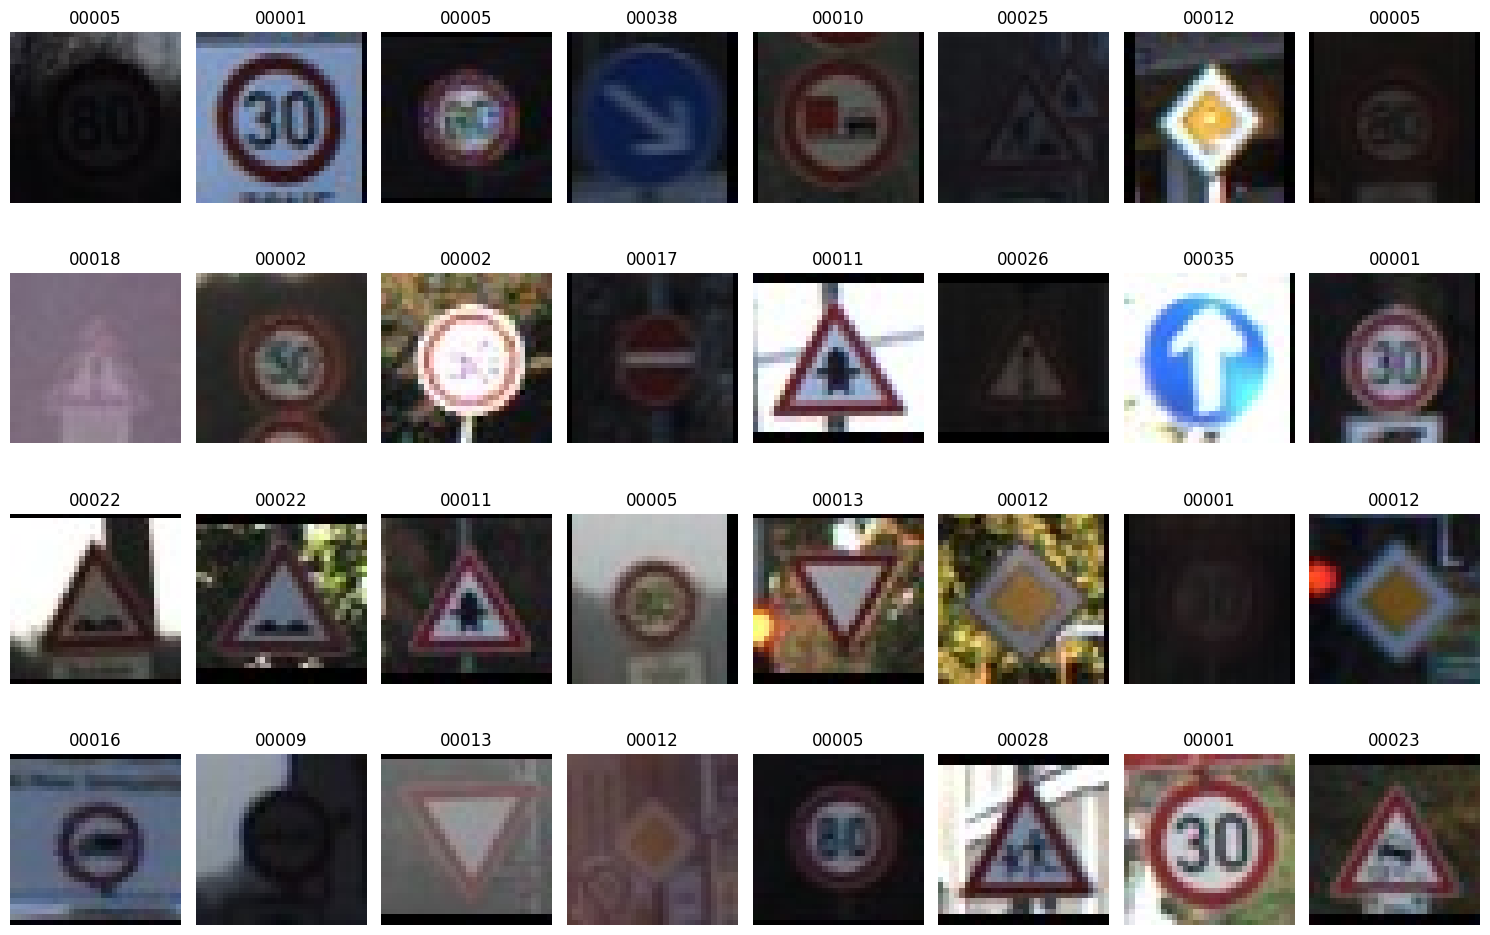

In [78]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


class_names = dataset.classes

# Get one batch of images and labels from the trainloader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Unnormalize the images for display
images = images * 0.5 + 0.5  # Reverse normalization

# Create a grid of images
grid_size = (4, 8)  # 4 rows and 8 columns
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 10))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Plot each image in the grid
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.permute(1, 2, 0))  # Convert from CHW to HWC
    ax.set_title(class_names[label])  # Display the class name
    ax.axis("off")

# Hide any unused subplots
for ax in axes[len(images):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [79]:
import torch.nn as nn


class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(ConditionalDiscriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim + num_classes, hidden_dim) # Take into account the labels
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x, labels):
        x = torch.flatten(x, 1)
        x = torch.cat([x, labels], dim=1)  # Concatenate labels
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [80]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_classes):
        super(ConditionalGenerator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim + num_classes, hidden_dim) # Take into account the labels
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x, labels):
        x = torch.cat([x, labels], dim=1) # Concatenate labels
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [81]:
import torch.optim as optim


# Models
latent_dim = 32
num_classes = 43
conditional_generator = ConditionalGenerator(latent_dim=latent_dim, hidden_dim=256, output_dim=3072, num_classes=num_classes).to(device)
conditional_discriminator = ConditionalDiscriminator( hidden_dim=256, input_dim=3072, num_classes=num_classes).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(conditional_generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(conditional_discriminator.parameters(), lr=0.00001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [82]:
import torch.nn.functional as F


fixed_noise = torch.randn(16, latent_dim,device=device)
fixed_labels_one_hot = F.one_hot(torch.arange(16, device=device), num_classes=43).float()

In [83]:
print(fixed_labels_one_hot.shape)

torch.Size([16, 43])


In [84]:
import numpy as np


G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):
        if i % 10 == 0:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            discriminator_optimizer.zero_grad()
            real_images, real_labels = data[0].to(device), data[1].to(device) # get also the labels
            real_labels_one_hot = F.one_hot(real_labels, num_classes=43).float() # convert to one-hot encoding
            b_size = real_images.size(0)
            label = torch.ones((b_size,), dtype=torch.float, device=device)
            output = conditional_discriminator(real_images, real_labels_one_hot).view(-1) # use conditional discriminator
            error_discriminator_real = criterion(output, label)
            discriminator_real_acc.append(output.mean().item())

            noise = torch.randn(b_size, latent_dim,device=device)
            random_labels = torch.randint(0, num_classes, (b_size,), device=device)  # Generqate random labels
            random_labels_one_hot = F.one_hot(random_labels, num_classes=num_classes).float()  # One-hot encode the labels
            fake_images = conditional_generator(noise, random_labels_one_hot) # use conditional generator
            label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
            output = conditional_discriminator(fake_images.detach(), random_labels_one_hot).view(-1) # use conditional discriminator
            error_discriminator_fake = criterion(output, label_fake)
            discriminator_fake_acc.append(output.mean().item())
            error_discriminator = error_discriminator_real + error_discriminator_fake
            error_discriminator.backward()
            discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        noise = torch.randn(b_size, latent_dim, device=device)
        random_labels = torch.randint(0, num_classes, (b_size,), device=device)  # Generqate random labels
        random_labels_one_hot = F.one_hot(random_labels, num_classes=num_classes).float()  # One-hot encode the labels
        fake_images = conditional_generator(noise, random_labels_one_hot) # use conditional generator
        label = torch.ones((b_size,), dtype=torch.float, device=device)
        output = conditional_discriminator(fake_images, random_labels_one_hot).view(-1)
        error_generator = criterion(output, label)
        error_generator.backward()
        D_G_z2 = output.mean().item()
        generator_optimizer.step()

        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = conditional_generator(fixed_noise, fixed_labels_one_hot).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    fake = conditional_generator(fixed_noise, fixed_labels_one_hot).detach().cpu()
grid = torchvision.utils.make_grid(fake, nrow=4, normalize=True)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.title(f"Generations")
plt.imshow(grid)
plt.axis('off')
plt.show()

In [ ]:
with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim,device=device)
    generations_gan = conditional_generator(fixed_noise)

In [ ]:
orig_data = torch.stack([x[0] for x in list(valid_subset)[:1000]])
orig_data = orig_data.view(-1, 3*32*32)

In [ ]:
from evaluator import Evaluator


evaluator = Evaluator(3*32*32, 512).to(device)
evaluator.load_state_dict(torch.load("evaluator.pth"))
evaluator.eval()

with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_gan = evaluator.get_features(generations_gan.to(device)).cpu()

In [ ]:
from fid import calculate_frechet_distance

for name, obj in zip(['orig','gan'],[dist_orig_data.numpy(),dist_gan.numpy()]):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(),obj)}")

In [ ]:
torch.save(conditional_generator.state_dict(), "cond_gan.pth")